# Data Set Information:

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes. 

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34]. 

## Attribute Information:

* ID number 
* Diagnosis (M = malignant, B = benign) 

Ten real-valued features are computed for each cell nucleus: 

* radius (mean of distances from center to points on the perimeter) 
* texture (standard deviation of gray-scale values) 
* perimeter 
* area 
* smoothness (local variation in radius lengths) 
* compactness (perimeter^2 / area - 1.0) 
* concavity (severity of concave portions of the contour) 
* concave points (number of concave portions of the contour) 
* symmetry 
* fractal dimension ("coastline approximation" - 1)

*Sources:*
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29 
https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/home

## Our Task
We will be using **FastAI's** Deep Learning framework to create a Neural Network to tackle this classification problem. Up till now, most structured/tabular datasets are tackling using Machine Learning techniques such as *Random Forest, Support Vector Machines, DecisionTrees, KNeighbors, etc.* We will be using a **Deep Neural Network** and experiment with various layer sizes.

In [1]:
# !pip install kaggle --upgrade
# !pip install fastai

In [2]:
from fastai.tabular import *
import torch
from torch.optim import *
import pandas as pd
import numpy as np
import os

In [4]:
# Making directory
!mkdir breast_cancer_data
path = './breast_cancer_data'

In [3]:
path = './breast_cancer_data'

In [5]:
# Downloading our data
!kaggle datasets download -d uciml/breast-cancer-wisconsin-data -f data.csv -p {path}

  0%|                                                | 0.00/122k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 122k/122k [00:00<00:00, 6.36MB/s]


In [4]:
os.listdir(path)

['data.csv', 'models']

### Exploring Data

In [5]:
df = pd.read_csv('./breast_cancer_data/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [6]:
# Dictionary describing the data
about_data = {
    'id': 'ID Number',
    'diagnosis': 'The diagnosis of breast tissue(M = Malignant, B = Benign)',
    'radius_mean': 'Mean of distances from center to points on the perimeter',
    'texture_mean': 'Standard deviation of gray-scale values',
    'perimeter_mean': 'Mean size of the core tumor',
    'area_mean': 'N/A',
    'smoothness_mean': 'Mean of local variation in radius lengths',
    'compactness_mean': 'Mean of perimeter^2 / area - 1.0', 
    'concavity_mean': 'Mean of severity of concave portions of the contour',
    'concave points_mean': 'Mean for number of concave portions of the contour',
    'symmetry_mean': 'N/A',
    'fractal_dimension_mean': 'Mean for coastline approximation - 1',
    'radius_se': 'Standard error for the mean of distances from center to points on the perimeter',
    'texture_se': 'Standard error for standard deviation of gray-scale values',
    'perimeter_se': 'N/A',
    'area_se': 'N/A',
    'smoothness_se': 'Standard error for local variation in radius lengths',
    'compactness_se': 'Standard error for perimeter^2 / area - 1.0',
    'concavity_se': 'Standard error for severity of concave portions of the contour',
    'concave points_se': 'Standard error for number of concave portions of the contour',
    'symmetry_se': 'N/A',
    'fractal_dimension_se': 'Standard error for coastline approximation - 1',
    'radius_worst': 'Worst or largest mean value for mean of distances from center to points on the perimeter',
    'texture_worst': 'Worst or largest mean value for standard deviation of gray-scale values',
    'perimeter_worst': 'N/A',
    'area_worst': 'N/A',
    'smoothness_worst': 'Worst or largest mean value for local variation in radius lengths',
    'compactness_worst': 'Worst or largest mean value for perimeter^2 / area - 1.0',
    'concavity_worst': 'Worst of largest mean value for severity of concave portions of the contour', 
    'concave points_worst': 'Worst or largest mean value for number of concave portions of the contour',
    'symmetry_worst': 'N/A',
    'fractal_dimension_worst': 'Worst or largest mean value for coastline approximation -1'
}

In [11]:
# taking a look at each column and counts
for c in df.columns:
    print(f'{c}: {df[c].nunique()}')

id: 569
diagnosis: 2
radius_mean: 456
texture_mean: 479
perimeter_mean: 522
area_mean: 539
smoothness_mean: 474
compactness_mean: 537
concavity_mean: 537
concave points_mean: 542
symmetry_mean: 432
fractal_dimension_mean: 499
radius_se: 540
texture_se: 519
perimeter_se: 533
area_se: 528
smoothness_se: 547
compactness_se: 541
concavity_se: 533
concave points_se: 507
symmetry_se: 498
fractal_dimension_se: 545
radius_worst: 457
texture_worst: 511
perimeter_worst: 514
area_worst: 544
smoothness_worst: 411
compactness_worst: 529
concavity_worst: 539
concave points_worst: 492
symmetry_worst: 500
fractal_dimension_worst: 535
Unnamed: 32: 0


In [7]:
# Creating Path Object
path = Path(path)
path.ls()

[PosixPath('breast_cancer_data/data.csv'),
 PosixPath('breast_cancer_data/models')]

## Experiment one
For this first experiment we will be using all columns except: id, Unnamed. With our dependent variable being: diagnosis

In [8]:
# First experiment, cont_names 1, dep_var, procs (normalization)
cont_names = []

for c in df.columns:
    if c == 'id' or c == 'Unnamed: 32' or c == 'diagnosis':
        pass
    else:
        cont_names.append(c)
        
dep_var = 'diagnosis'
procs = [FillMissing, Normalize]

In [86]:
# Creating out data object, using DataBlock API
seed = np.random.seed(42)

data = (TabularList.from_df(df, path=path, cont_names=cont_names, procs=procs)
                   .random_split_by_pct(.20, seed)
                   .label_from_df(cols=dep_var)
                   .databunch(num_workers=2, bs=124))

In [10]:
data.show_batch(rows=5)

radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,target
-0.5879,-0.0806,-0.6324,-0.5941,-0.8644,-0.8788,-1.0339,-1.0556,-0.9092,-0.3195,-0.5728,-0.1122,-0.6371,-0.4777,0.0574,-0.7978,-0.8492,-1.0208,-0.0824,-0.3861,-0.5453,0.2206,-0.6209,-0.5564,-0.1292,-0.7591,-1.0974,-0.9744,-0.0342,-0.1751,B
-0.0800,0.0814,-0.1363,-0.1781,-0.6509,-0.7767,-0.9589,-0.6747,-0.9092,-0.8395,-0.2254,0.8361,-0.2642,-0.2327,-0.3864,-0.7984,-0.8499,-0.7746,-0.0429,-0.5404,-0.1351,0.3728,-0.1936,-0.2331,-0.8612,-0.8927,-1.0857,-0.8528,-0.6142,-0.8059,B
-0.0261,-0.7564,-0.0909,-0.1256,-0.8128,-0.8596,-0.6807,-0.5030,-0.3349,-0.5275,-0.0593,-0.3033,-0.1131,-0.1670,0.3202,-0.6904,-0.5238,-0.4546,-0.0540,-0.3587,-0.1289,-0.6574,-0.1847,-0.2316,-0.5316,-0.8224,-0.7793,-0.6142,-0.2792,-0.6320,B
-0.5283,2.4813,-0.6010,-0.5374,-1.3566,-1.3351,-1.1292,-1.2794,-0.3818,-0.4415,0.1385,4.3859,0.0028,-0.1166,0.1099,-0.9445,-1.0345,-1.8970,1.3496,-0.2483,-0.5845,1.9816,-0.6644,-0.5628,-1.6137,-1.2850,-1.3126,-1.7519,-0.7786,-0.8963,B
1.9739,1.6944,2.0930,1.8510,1.3021,3.4109,2.0266,2.6658,2.1252,1.5524,0.7858,-0.8137,0.7418,0.8613,-0.9090,1.1799,0.1952,0.6016,-0.3098,0.5302,2.1430,1.2493,2.0559,2.0892,0.7354,3.1868,1.9242,2.6795,1.8908,2.3851,M


### Experiment Model One

In [135]:
arch = [200, 100, 50]
learn = tabular_learner(data, arch, metrics=[accuracy], ps=0.4)

In [97]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU(inplace)
    (8): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=300, out_features=400, bias=True)
    (10): ReLU(inplace)
    (11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=400, out_features=200, bias=True)
    (13): ReLU(inplace)
    (14): BatchNorm1d(200, 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


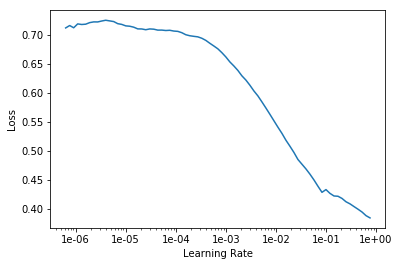

In [57]:
learn.lr_find()
learn.recorder.plot()

In [136]:
lr = 5e-2

In [137]:
learn.fit_one_cycle(20, slice(lr), wd=1e-3)

epoch,train_loss,valid_loss,accuracy
1,0.622975,0.682466,0.876106
2,0.486523,0.566042,0.893805
3,0.386181,0.225469,0.946903
4,0.319405,0.097872,0.955752
5,0.268396,0.130560,0.964602
6,0.233098,0.162212,0.964602
7,0.208527,0.312243,0.955752
8,0.195500,0.179518,0.964602
9,0.181784,0.158005,0.973451
10,0.167642,0.086557,0.955752


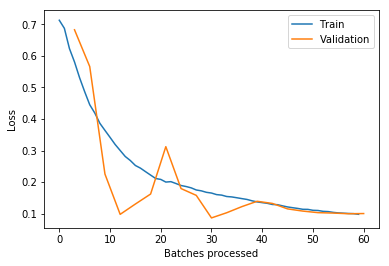

In [138]:
learn.recorder.plot_losses()